## Cartpole
### Michael Pauleen

In [2]:
import gym
import gym.spaces
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [3]:
%matplotlib inline

In [4]:
env = gym.make('CartPole-v0')
obs = env.reset()
n_actions = env.action_space.n
gamma = 0.95

In [10]:
state_size = len(obs)

max_episodes = 10000
learning_rate = 0.01

n_hidden = 10


In [6]:
def normalize_reward(r):
    discounted =[0]*len(r)
    cumulative = 0.0
    for i in reversed(range(len(r))):
        cumulative = cumulative * gamma + r[i]
        discounted[i] = cumulative
    mean = np.mean(discounted)
    std = np.std(discounted)
    discounted = (discounted - mean)/std
    return discounted

In [7]:
def preprocess(image):
    """ prepro 210x160x3 uint8 frame into 6400 (80x80) 2D float array """
    image = image[35:195] # crop
    image = image[::2,::2,0] # downsample by factor of 2
    image[image == 144] = 0 # erase background (background type 1)
    image[image == 109] = 0 # erase background (background type 2)
    image[image != 0] = 1 # everything else (paddles, ball) just set to 1
    return np.reshape(image.astype(np.float).ravel(), [80,80])

## Construct NN 

In [8]:
tf.reset_default_graph()

input_state = tf.placeholder(tf.float32, shape=(None, state_size), name="input_state")
action_ = tf.placeholder(tf.int32, shape=(None), name="action")
reward_ = tf.placeholder(tf.float32, shape=(None), name = 'reward')

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(input_state, n_hidden, name="hidden1",
                              activation=tf.nn.relu, kernel_initializer = tf.contrib.layers.xavier_initializer())

    hidden2 = tf.layers.dense(hidden1, n_hidden, name="hidden2",
                              activation=tf.nn.relu,
                             kernel_initializer = tf.contrib.layers.xavier_initializer())

    logits = tf.layers.dense(hidden2, n_actions, name="outputs")
    y_proba = tf.nn.softmax(logits)


with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=action_, logits=logits) #for this fucntion you do not need to use one hot endcoding
    loss = tf.reduce_mean(xentropy*reward_, name="loss")


with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)


In [9]:
all_rewards = []
running_mean = []
saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(max_episodes):

        #initialize lists to keep track of rewards, states and actions
        r = []
        observations =[]
        actions =[]

        state = env.reset() # initialize the game by resetting. we assign the initial state to variable state. Every time the game finishes you need to reset the game.

        while True:
            action_probabilities = sess.run(y_proba, feed_dict={input_state: state.reshape([1,4])})
            action = np.random.choice(range(n_actions), p=action_probabilities.ravel()) #choose random action
            next_state, reward, done, info = env.step(action) #take the actions and see the next state, reward, if the game is finished or not and some info about the game.
            #keep track of rewards, states and actions
            r.append(reward)
            observations.append(state)
            actions.append(action)
            
            if done:
                normalized_reward = normalize_reward(r)
                loss_, _ = sess.run([loss, training_op], feed_dict={input_state: np.vstack(np.array(observations)),
                                                                 action_: actions,
                                                                 reward_: normalized_reward
                                                                })
                break
            state = next_state #assign next_state to state

        episode_reward = sum(r)
        all_rewards.append(episode_reward)
        last_hundred = all_rewards[i-100:i]
        running_mean.append(np.mean(last_hundred))
        if np.mean(last_hundred) >= 195:
            saver.save(sess, "./cartpole-model.ckpt")
            print("Episode:", i,", Reward:", np.mean(all_rewards[i-100:i]), "Max Reward:", max(all_rewards))
            break
        if i%500 == 0:
            print("Episode:", i,", Reward:", np.mean(all_rewards[i-100:i]), "Max Reward:", max(all_rewards))

/Users/michaelpauleen/miniconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/michaelpauleen/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Episode: 0 , Reward: nan Max Reward: 10.0
Episode: 500 , Reward: 28.79 Max Reward: 104.0
Episode: 1000 , Reward: 39.7 Max Reward: 171.0
Episode: 1500 , Reward: 48.74 Max Reward: 177.0
Episode: 2000 , Reward: 48.78 Max Reward: 200.0
Episode: 2500 , Reward: 70.85 Max Reward: 200.0
Episode: 3000 , Reward: 75.89 Max Reward: 200.0
Episode: 3500 , Reward: 139.1 Max Reward: 200.0
Episode: 4000 , Reward: 165.85 Max Reward: 200.0
Episode: 4500 , Reward: 180.59 Max Reward: 200.0
Episode: 5000 , Reward: 177.29 Max Reward: 200.0
Episode: 5500 , Reward: 187.6 Max Reward: 200.0
Episode: 6000 , Reward: 190.81 Max Reward: 200.0
Episode: 6500 , Reward: 187.98 Max Reward: 200.0
Episode: 7000 , Reward: 172.66 Max Reward: 200.0
Episode: 7500 , Reward: 179.45 Max Reward: 200.0
Episode: 8000 , Reward: 182.26 Max Reward: 200.0
Episode: 8500 , Reward: 190.08 Max Reward: 200.0
Episode: 9000 , Reward: 174.33 Max Reward: 200.0
Episode: 9500 , Reward: 172.98 Max Reward: 200.0


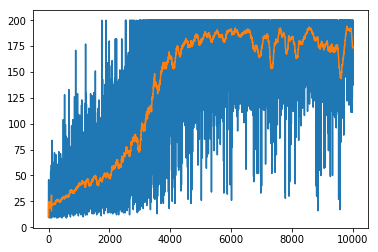

In [12]:
plt.plot(range(len(all_rewards)), all_rewards, range(len(all_rewards)), running_mean)